<h1><center>Image Caption Generator</center></h1>

#### In this project, I use CNN and RNN techniques to build an image caption generator.


#### Feature Extraction:
We will use pre-trained model: Xception to exract features

#### Generate Captions:
Using LSTM (Long Short Term Memory), which is a type a RNN capable of predicting text based on previously fed text, to generate captions 

In [1]:
# import necessary libraries 

import string
import numpy as np
from PIL import Image
import os
from pickle import dump,load

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

Using TensorFlow backend.


/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#### Build functions to load, clean and assign data to a dictionary

In [2]:
# create functions to manipulate image and caption data


# image and captions dicitonary function
def all_img_captions(filename):
    '''
    loads text file and and maps image names with their captions (key = image name, value = list of length 5) )
    '''
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions


# load file function
def load_doc(filename):
    '''
    loads a file, reads its content as a string
    '''
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text




# Data cleaning function
def cleaning_text(captions):
    
    '''
    performs text cleaning:
    
    1. removing punctuations
    2. numbers and hanging 's
    3. converting to lowercase
    
    returns (cleaned) descriptions
    '''
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove 1 char words (hanging 's and a's)
            desc = [word for word in desc if(len(word)>1)]
            #remove token with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


# build vocabulary of all unique words
def text_vocabulary(descriptions):
    
    '''
    creates a set of all unique words in descriptions
    
    '''
    
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


# save all descriptions in one file 
def save_descriptions(descriptions, filename):
    '''
    saves descriptions to a txt file
    
    '''
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()  

### Create the descriptions file and the vocabulary list

In [3]:
# create variables for the file's paths
dataset_text = "/Users/ahmedhatahet/Downloads/Flickr8k_text/"
dataset_images = "/Users/ahmedhatahet/Downloads/Flicker8k_Dataset"

# prepare text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

# load the file that contains the image names and captions data as a dictionary
descriptions = all_img_captions(filename)
#print the length
print("Length of descriptions =" ,len(descriptions))

# clean the descriptions
clean_descriptions = cleaning_text(descriptions)

# build vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
#print its length
print("Length of vocabulary = ", len(vocabulary))

# save descriptions to file 
save_descriptions(clean_descriptions, "descriptions.txt") 


Length of descriptions = 8092
Length of vocabulary =  8763


### Extract feature vectors from images

#### Extract the features using Xception model.

In [4]:
def extract_features(directory):
    '''
    extracts the features from our images using Xception pre-trained model and return them as a dictionary (key = image name, value = array of features (len = 2048))
    '''
    model = Xception(include_top = False, pooling = 'avg')
    features = {}
    
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis = 0)
        
        image = image/127.5
        image = image - 1.0
        
        feature = model.predict(image)
        features[img] = feature
    return features


In [5]:
# apply feature extraction
features = extract_features(dataset_images)
# dump the features dictionary in feature.p pickle file
dump(features, open("features.p", "wb"))

## Loading dataset for training the model

#### Create functions to load image descriptions and features

In [7]:
# create functions for loading

def load_photos(filename):
    '''
    load photo names file and return them as a list
    
    '''
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    
    return photos

def load_descriptions(filename, photos):
    '''
    creates a dictionary for photo names and their captions
    '''
    
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1:
            continue
            
        image = words[0]
        image_caption = words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            # add start and end identifiers so the LSTM model identify the start and end for each caption
            desc = '<start>' + " ".join(image_caption) + '<end>'
            descriptions[image].append(desc)
            
    return descriptions

def load_features(photos):
    '''
    creates a dictionary for image names and their features 

    '''
    
    all_features = load(open("features.p", "rb"))
    
    features = {k:all_features[k] for k in photos}
    return features

#### Load the datasets containing image names and combine them with descriptions.

In [8]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

# get the photo names as a list
train_imgs = load_photos(filename)

# get the photo names and their descriptions as a dictionary
train_descriptions = load_descriptions("descriptions.txt", train_imgs)

# get the photo names and their features as a dictionary
train_features = load_features(train_imgs)

In [108]:
print(len(train_descriptions))
print(len(train_features))


6000
6000


## Tokenizing the vocabulary

#### tokenize descriptions by mapping each word to a unique index value

#### we will use Tokenizer from Keras

####  Create necessary functions

In [10]:
# tokenizer function

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# convert descriptions dictionary to a list of descriptions

def dict_to_list(descriptions):
    all_desc = []
    
    for key in descriptions.keys():
        [all_desc.append(d)for d in descriptions[key]]
    return all_desc

from keras.preprocessing.text import Tokenizer

#### Map each word in descriptions to a unique index value.

In [22]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer,open('tokenizer.p', 'wb'))

# get the vocab size
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7577


#### calculate the maximum lengths of descriptions for model structure parameters

In [12]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

### Create Data Generator

We will create a data generator with an input and an output

##### input: features, descriptions of the images
##### output: the target that the model has to predict

#### Create necessary functions

In [13]:
# data generator function
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        # loop through descriptions
        for key, description_list in descriptions.items():
            # retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]
            
# helper function to create sequences
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = [],[],[]
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]
            
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
    
    
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
    
    

((47, 2048), (47, 32), (47, 7577))

## CNN_RNN model

we will use the Keras model from Functional API. 

The model will be divided into 3 main parts.


Feature Extracter:

- input layer (2048 nodes)

- drop outlayer (2048 nodes)

- dense layer (256 nodes of features reduced from 2048)

Sequence Processor:

- input layer (32 nodes)
- embedded layer (256)
- dropout layer (256)
- LSTM layer (256)

Encoder (merger):

- add layer (add feature extracter with sequence processers ouputs
- dense layer (256)
- dense layer (7677) <- size of vocabulary

In [25]:
from keras.utils import plot_model


def define_model(vocab_size, max_length):
    
    # Feature Extracter:
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation = 'relu')(fe1)
    
    
    # Sequence Processor:
    inputs2 = Input(shape = (max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256,activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
    
    
    # model
    model = Model(inputs = [inputs1, inputs2], outputs = outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')
    
    # summary
    print(model.summary())
    #plot_model(model, to_file = 'model.png', show_shapes = True)
    
    
    return(model)
    

## Model Training

In [31]:
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
#os.mkdir("models")

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    
    model.save("models/model_" + str(i) + ".h5")

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 32, 256)      1939712     input_15[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 2048)         0           input_14[0][0]                   
____________________________________________________________________________________________

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 996s 166ms/step - loss: 4.4805
Epoch 1/1
6000/6000 [==============================] - 1022s 170ms/step - loss: 3.6357
Epoch 1/1
6000/6000 [==============================] - 1077s 180ms/step - loss: 3.3536
Epoch 1/1
6000/6000 [==============================] - 1020s 170ms/step - loss: 3.1812
Epoch 1/1
6000/6000 [==============================] - 935s 156ms/step - loss: 3.0653
Epoch 1/1
6000/6000 [==============================] - 955s 159ms/step - loss: 2.9813
Epoch 1/1
6000/6000 [==============================] - 964s 161ms/step - loss: 2.9105
Epoch 1/1
6000/6000 [==============================] - 1019s 170ms/step - loss: 2.8540
Epoch 1/1
6000/6000 [==============================] - 1003s 167ms/step - loss: 2.8149
Epoch 1/1
6000/6000 [==============================] - 1028s 171ms/step - loss: 2.7816


## Model testing

In [32]:
import matplotlib.pyplot as plt
import argparse

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "





start dog is running through the water end


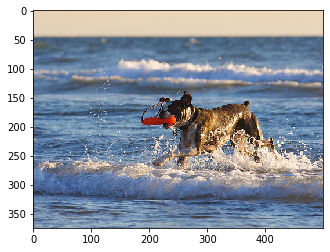

In [107]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=False, help="Image Path")
args = vars(ap.parse_args())
img_path = '/Users/ahmedhatahet/Downloads/Flicker8k_Dataset/3183875944_b2be694e06.jpg'

def extract_features(filename, model):
        #try:
        image = Image.open(filename)
        #except:
            #print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
%tb

In [53]:
import sys
sys.argv[1:]

[]

In [57]:
import sys
sys.argv=['']
del sys